# 04 Benchmark Attribution and Alpha Decomposition

This notebook attributes strategy returns to broad benchmark exposures and residual alpha.

What it does:
- Runs a case study strategy (default: Black-Litterman)
- Builds benchmark return series (SPY + sector ETFs when available)
- Falls back to transparent ticker proxies when ETF data is missing
- Fits OLS attribution and visualizes beta/loadings + contribution split


In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT / "src"))

from portfolio_bl.backtest.metrics import infer_periods_per_year
from portfolio_bl.config import load_config
from portfolio_bl.data.prices import load_prices_csv, to_return_matrix
from portfolio_bl.pipeline import run_case_study

plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:.6f}".format


In [2]:
# Pick case study and strategy here
person_key = "buffett"
strategy_name = "black_litterman"  # disclosed | mean_variance | black_litterman

cfg = load_config(ROOT / "configs/case_studies.yaml")
result = run_case_study(cfg, person_key=person_key, view_confidence=0.65)

strategy_returns = result.strategy_results[strategy_name].returns.sort_index()
periods_per_year = infer_periods_per_year(strategy_returns.index)

print(f"Case: {result.person_label}")
print(f"Strategy: {strategy_name}")
print(f"Backtest observations: {len(strategy_returns)}")
print(f"Periods/year inferred: {periods_per_year}")


Case: Warren Buffett
Strategy: black_litterman
Backtest observations: 10
Periods/year inferred: 12


In [3]:
prices = load_prices_csv(cfg.prices_path)
all_returns = to_return_matrix(prices).sort_index()
all_returns.head()


ticker,AAPL,JPM,MSFT,NVDA,TSLA,XOM
date,,,,,,
2024-02-29,0.013120,0.010394,0.009356,0.011187,0.013007,0.012218
2024-03-31,0.012950,0.010287,0.009214,0.011022,0.012840,0.012071
2024-04-30,0.012839,0.010248,0.009185,0.010943,0.012721,0.012031
2024-05-31,0.012622,0.010079,0.009047,0.010784,0.012518,0.011785
2024-06-30,0.012465,0.009979,0.009020,0.010709,0.012363,0.011648


In [4]:
def build_benchmarks(all_returns: pd.DataFrame, universe: list[str]) -> tuple[pd.DataFrame, dict[str, str]]:
    benchmark_candidates = {
        "SPY": ["SPY", "IVV", "VOO"],
        "Tech": ["XLK", "VGT", "QQQ"],
        "Energy": ["XLE", "VDE"],
        "Financials": ["XLF", "VFH"],
        "ConsumerDisc": ["XLY", "VCR"],
    }

    out: dict[str, pd.Series] = {}
    source: dict[str, str] = {}

    for bench, candidates in benchmark_candidates.items():
        found = next((ticker for ticker in candidates if ticker in all_returns.columns), None)
        if found is not None:
            out[bench] = all_returns[found]
            source[bench] = found

    def add_proxy_if_missing(bench: str, proxy_tickers: list[str], fallback: pd.Series | None = None, fallback_name: str = ""):
        if bench in out:
            return
        available = [t for t in proxy_tickers if t in all_returns.columns]
        if available:
            out[bench] = all_returns[available].mean(axis=1)
            source[bench] = "proxy:" + ",".join(available)
        elif fallback is not None:
            out[bench] = fallback
            source[bench] = fallback_name

    eq_universe = all_returns[[t for t in universe if t in all_returns.columns]].mean(axis=1)
    add_proxy_if_missing("SPY", ["SPY", "IVV", "VOO"], fallback=eq_universe, fallback_name="proxy:eq_weight_universe")
    add_proxy_if_missing("Tech", ["AAPL", "MSFT", "NVDA", "TSLA"], fallback=eq_universe, fallback_name="proxy:eq_weight_universe")
    add_proxy_if_missing("Energy", ["XOM", "CVX"], fallback=eq_universe, fallback_name="proxy:eq_weight_universe")
    add_proxy_if_missing("Financials", ["JPM", "BAC", "WFC"], fallback=eq_universe, fallback_name="proxy:eq_weight_universe")
    add_proxy_if_missing("ConsumerDisc", ["TSLA", "AMZN"], fallback=eq_universe, fallback_name="proxy:eq_weight_universe")

    bench_df = pd.DataFrame(out).dropna(how="all").sort_index()
    return bench_df, source


benchmarks, benchmark_sources = build_benchmarks(all_returns, result.universe)
common_idx = strategy_returns.index.intersection(benchmarks.index)

if len(common_idx) < 6:
    raise ValueError("Not enough overlap between strategy and benchmark returns for attribution.")

y = strategy_returns.loc[common_idx]
X = benchmarks.loc[common_idx].fillna(0.0)

pd.DataFrame({"source": benchmark_sources}).T


,SPY,Tech,Energy,Financials,ConsumerDisc
source,proxy:eq_weight_universe,"proxy:AAPL,MSFT,NVDA,TSLA",proxy:XOM,proxy:JPM,proxy:TSLA


In [5]:
def ols_attribution(y: pd.Series, X: pd.DataFrame, periods_per_year: int) -> dict:
    X_design = np.column_stack([np.ones(len(X)), X.to_numpy()])
    coef = np.linalg.lstsq(X_design, y.to_numpy(), rcond=None)[0]

    alpha = float(coef[0])
    betas = pd.Series(coef[1:], index=X.columns, name="beta")

    fitted = pd.Series(X_design @ coef, index=y.index, name="fitted")
    resid = y - fitted

    y_var = float(y.var(ddof=0))
    resid_var = float(resid.var(ddof=0))
    r2 = float("nan") if y_var <= 0 else 1.0 - resid_var / y_var

    # Arithmetic annualized contribution decomposition
    factor_contrib = (betas * X.mean()) * periods_per_year
    alpha_contrib = alpha * periods_per_year
    strategy_mean_ann = float(y.mean() * periods_per_year)
    unexplained = strategy_mean_ann - alpha_contrib - float(factor_contrib.sum())

    attribution_table = pd.DataFrame({
        "beta": betas,
        "mean_factor_return": X.mean(),
        "annual_contribution": factor_contrib,
    }).sort_values("annual_contribution", ascending=False)

    summary = pd.Series({
        "alpha_per_period": alpha,
        "alpha_annual_arithmetic": alpha_contrib,
        "strategy_mean_annual_arithmetic": strategy_mean_ann,
        "explained_annual_arithmetic": float(factor_contrib.sum()),
        "residual_annual_arithmetic": unexplained,
        "r2": r2,
    })

    return {
        "betas": betas,
        "fitted": fitted,
        "residual": resid,
        "attribution_table": attribution_table,
        "summary": summary,
    }


attr = ols_attribution(y, X, periods_per_year=periods_per_year)
attr["summary"]


alpha_per_period                   0.001290
alpha_annual_arithmetic            0.015476
strategy_mean_annual_arithmetic    0.108887
explained_annual_arithmetic        0.093411
residual_annual_arithmetic        -0.000000
r2                                 0.999998
dtype: float64

In [6]:
attr["attribution_table"]


,beta,mean_factor_return,annual_contribution
SPY,3.129253,0.008936,0.335541
ConsumerDisc,1.555097,0.010626,0.198289
Energy,-0.388906,0.009037,-0.042173
Financials,-0.809503,0.008187,-0.079529
Tech,-2.744257,0.009678,-0.318716


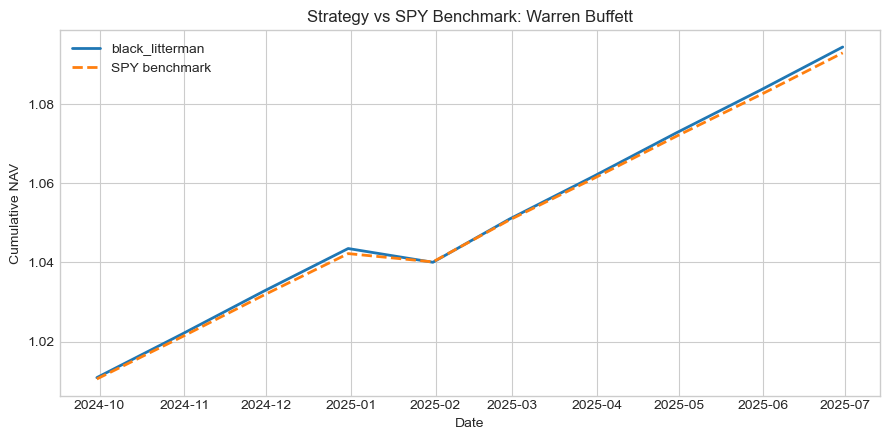

In [7]:
# 1) Equity curves: strategy vs SPY
spy = X["SPY"]
equity = pd.DataFrame({
    "strategy": (1.0 + y).cumprod(),
    "SPY": (1.0 + spy).cumprod(),
})

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(equity.index, equity["strategy"], label=strategy_name, linewidth=2)
ax.plot(equity.index, equity["SPY"], label="SPY benchmark", linewidth=2, linestyle="--")
ax.set_title(f"Strategy vs SPY Benchmark: {result.person_label}")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative NAV")
ax.legend()
plt.tight_layout()
plt.show()


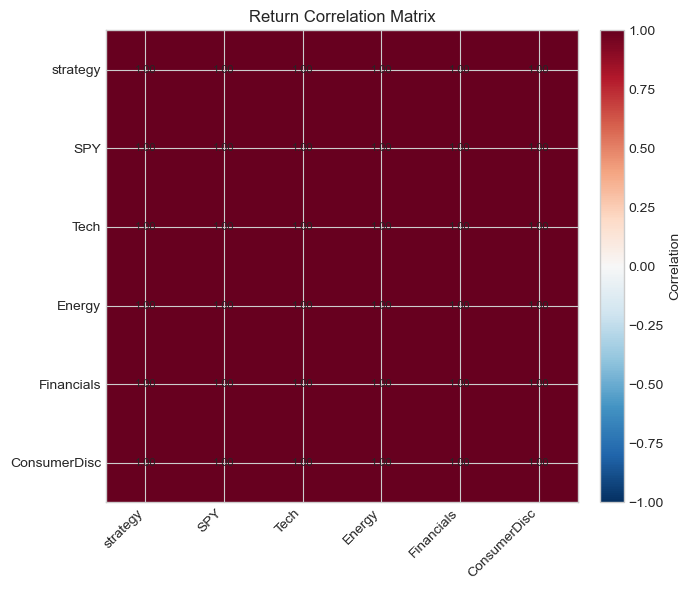

In [8]:
# 2) Correlation heatmap
corr_df = pd.concat([y.rename("strategy"), X], axis=1).corr()

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr_df.values, vmin=-1, vmax=1, cmap="RdBu_r")
ax.set_xticks(range(len(corr_df.columns)))
ax.set_xticklabels(corr_df.columns, rotation=45, ha="right")
ax.set_yticks(range(len(corr_df.index)))
ax.set_yticklabels(corr_df.index)
ax.set_title("Return Correlation Matrix")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Correlation")

for i in range(corr_df.shape[0]):
    for j in range(corr_df.shape[1]):
        ax.text(j, i, f"{corr_df.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()


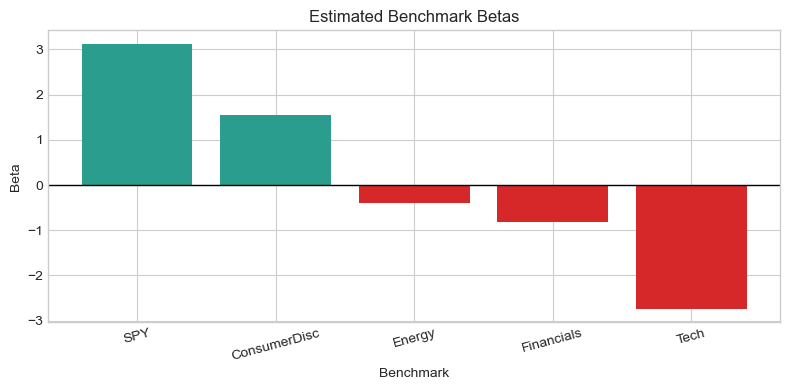

In [9]:
# 3) Factor betas
betas = attr["betas"].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
colors = ["#2A9D8F" if b >= 0 else "#D62828" for b in betas.values]
ax.bar(betas.index, betas.values, color=colors)
ax.axhline(0, color="black", linewidth=1)
ax.set_title("Estimated Benchmark Betas")
ax.set_ylabel("Beta")
ax.set_xlabel("Benchmark")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


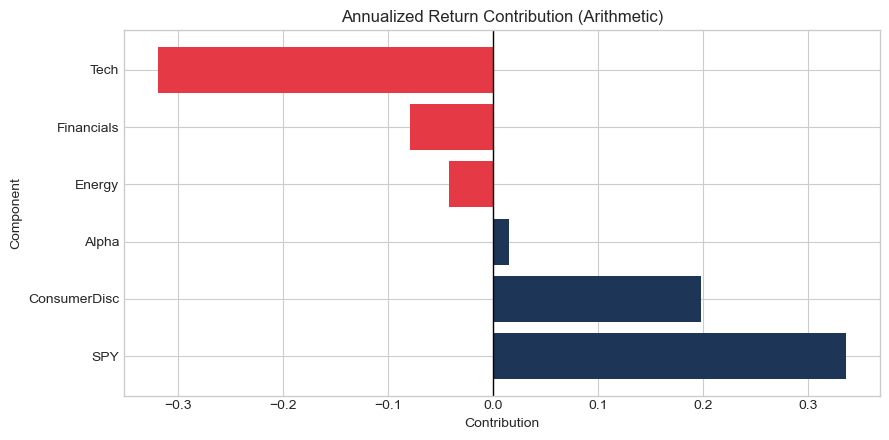

In [10]:
# 4) Annual contribution decomposition (arithmetic)
contrib = attr["attribution_table"]["annual_contribution"].copy()
contrib.loc["Alpha"] = attr["summary"]["alpha_annual_arithmetic"]
contrib = contrib.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(9, 4.5))
colors = ["#1D3557" if c >= 0 else "#E63946" for c in contrib.values]
ax.barh(contrib.index, contrib.values, color=colors)
ax.axvline(0, color="black", linewidth=1)
ax.set_title("Annualized Return Contribution (Arithmetic)")
ax.set_xlabel("Contribution")
ax.set_ylabel("Component")
plt.tight_layout()
plt.show()


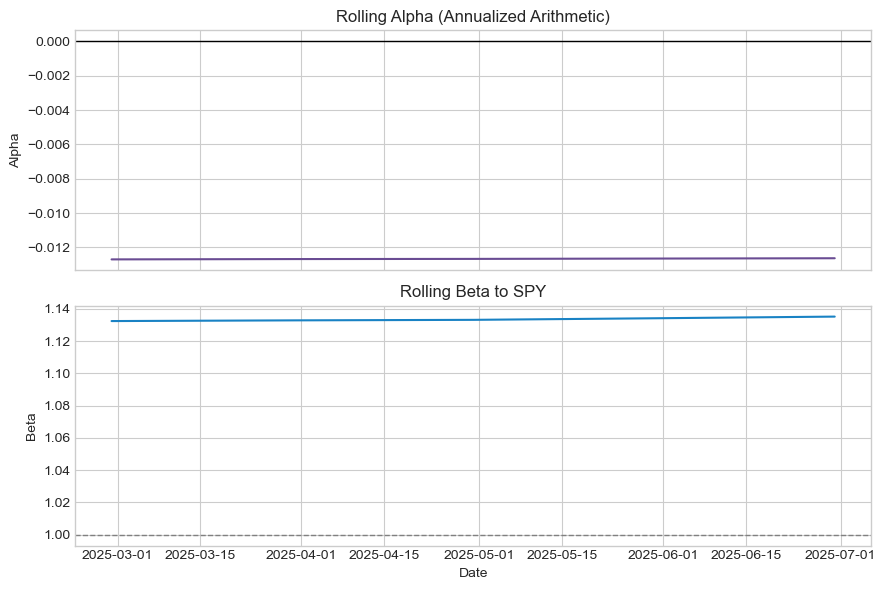

In [11]:
# 5) Rolling single-factor diagnostics (strategy vs SPY)
def rolling_alpha_beta(y: pd.Series, x: pd.Series, window: int = 12) -> pd.DataFrame:
    out = []
    n = len(y)
    if n < window:
        window = max(6, n // 2)

    for end in range(window, n + 1):
        yw = y.iloc[end - window : end]
        xw = x.iloc[end - window : end]
        Xw = np.column_stack([np.ones(len(xw)), xw.to_numpy()])
        coef = np.linalg.lstsq(Xw, yw.to_numpy(), rcond=None)[0]
        out.append((y.index[end - 1], float(coef[0]), float(coef[1])))

    return pd.DataFrame(out, columns=["date", "alpha", "beta"]).set_index("date")


rolling = rolling_alpha_beta(y, spy, window=12)

fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
axes[0].plot(rolling.index, rolling["alpha"] * periods_per_year, color="#6A4C93")
axes[0].axhline(0, color="black", linewidth=1)
axes[0].set_title("Rolling Alpha (Annualized Arithmetic)")
axes[0].set_ylabel("Alpha")

axes[1].plot(rolling.index, rolling["beta"], color="#1982C4")
axes[1].axhline(1.0, color="gray", linestyle="--", linewidth=1)
axes[1].set_title("Rolling Beta to SPY")
axes[1].set_ylabel("Beta")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()


## Interpretation Guide

- `beta` shows directional exposure to each benchmark return stream.
- `alpha_annual_arithmetic` is the regression intercept annualized arithmetically.
- `r2` indicates how much variance is explained by the chosen benchmark set.
- If ETF tickers are absent in your price file, proxy construction is shown in the `source` table.
